In [1]:
from dmp import DMPs
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class DMP_rhythmic(DMPs):
    def __init__(self, **kwargs):
        super(DMP_rhythmic, self).__init__(pattern='rhythmic', **kwargs)
        
        self.bfs_center_term()
        
        self.h = np.ones(self.n_bfs)*self.n_bfs # 1.75
        
        self.check_offset()
    
    def bfs_center_term(self):
        c = np.linspace(0, self.cs.runTime, self.n_bfs + 1)
        c = c[0:-1]
        self.c = c
    
    def f_front_term(self, x, dmp_idx):
        if isinstance(x, np.ndarray):
            return np.ones(x.shape)
        
        return 1

    def gen_goal(self, y_des):
        """Generate the goal for path imitation.
        For rhythmic DMPs the goal is the average of the
        desired trajectory.

        y_des np.array: the desired trajectory to follow
        """
        goal = np.zeros(self.n_dmps)
        for n in range(self.n_dmps):
            num_idx = ~np.isnan(y_des[n])  # ignore nan's when calculating goal
            goal[n] = .5 * (y_des[n, num_idx].min() +
                            y_des[n, num_idx].max())

        return goal
    
    def gen_psi(self, x):
        if isinstance(x, np.ndarray):
            x = x[:, None]
        return np.exp(self.h * (np.cos(x - self.c) - 1))
    
    def f_weight_term(self, f_target):
        x_track = np.zeros(self.cs.n_step)
        for i in range(self.cs.n_step):
            x_track[i] = self.cs.step()
        psi_track = self.gen_psi(x_track)

        # efficiently calculate BF weights using weighted linear regression
        for d in range(self.n_dmps):
            for b in range(self.n_bfs):
                self.w[d, b] = (np.dot(psi_track[:, b], f_target[:, d]) /
                                (np.sum(psi_track[:, b]) + 1e-10))

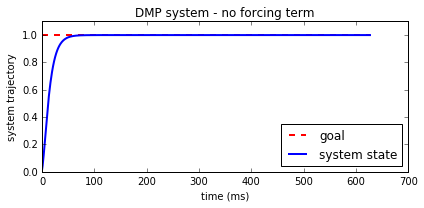

In [3]:
# test normal run
dt = 0.01
runTime = 2*np.pi
n_dmps = 1
n_bfs = 10

dmp = DMP_rhythmic(dt=dt, runTime=runTime, n_dmps=n_dmps, n_bfs=n_bfs)
y_traj = np.zeros((dmp.n_step, dmp.n_dmps))
dy_traj = np.zeros((dmp.n_step, dmp.n_dmps))
ddy_traj = np.zeros((dmp.n_step, dmp.n_dmps))
for i in range(dmp.n_dmps):
    for j in range(dmp.n_step):
        y_traj[j, i], dy_traj[j, i], ddy_traj[j, i] = dmp.step()
        
plt.figure(1, figsize=(6, 3))
plt.plot(np.ones(len(y_traj))*dmp.goal, 'r--', lw=2)
plt.plot(y_traj, lw=2)
plt.title('DMP system - no forcing term')
plt.xlabel('time (ms)')
plt.ylabel('system trajectory')
plt.ylim([0, 1.1])
plt.legend(['goal', 'system state'], loc='lower right')
plt.tight_layout()
plt.show()

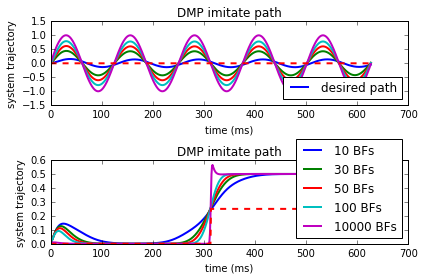

In [5]:
# test imitation of path runv
dt = 0.01
runTime = 2*np.pi
n_dmps = 2

plt.figure(2, figsize=(6, 4))
bfs = [10, 30, 50, 100, 10000]
n_bfs = len(bfs)

# a straight line to target
path1 = np.sin(np.arange(0, 2*np.pi, .01)*5)
# a strange path to target
path2 = np.zeros(path1.shape)
path2[int(len(path2) / 2.):] = .5

for idx, value in enumerate(bfs):
    dmp = DMP_rhythmic(n_dmps=n_dmps, runTime=runTime, dt=dt, n_bfs=value)
    
    dmp.imitate_path(y_des=np.array([path1, path2]))

    
    y_traj = np.zeros((dmp.n_step, dmp.n_dmps))
    dy_traj = np.zeros((dmp.n_step, dmp.n_dmps))
    ddy_traj = np.zeros((dmp.n_step, dmp.n_dmps))
#     for i in range(dmp.n_dmps):
#         for j in range(dmp.n_step):
#             y_traj[j, i], dy_traj[j, i], ddy_traj[j, i] = dmp.step()
    for i in range(dmp.n_step):
        y_traj[i], dy_traj[i], ddy_traj[i] = dmp.step()
    
    plt.figure(2)
    plt.subplot(211)
    plt.plot(y_traj[:, 0], lw=2)
    plt.subplot(212)
    plt.plot(y_traj[:, 1], lw=2)
    
    
plt.subplot(211)
plt.plot(path1 / path1[-1] * dmp.goal[0], 'r--', lw=2)
plt.title('DMP imitate path')
plt.xlabel('time (ms)')
plt.ylabel('system trajectory')
plt.legend(['desired path'], loc='lower right')
plt.subplot(212)
plt.plot(path2 / path2[-1] * dmp.goal[1], 'r--', lw=2)
plt.title('DMP imitate path')
plt.xlabel('time (ms)')
plt.ylabel('system trajectory')
plt.legend(['%i BFs' % i for i in bfs], loc='lower right')

plt.tight_layout()
plt.show()